<a href="https://colab.research.google.com/github/MinGyeongdo/MultiLabel-foodimg-classification/blob/main/model_create.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 이미지, 라벨 데이터 전처리


In [3]:
import pandas as pd
import numpy as np
import random
from random import randrange
import cv2
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Activation, Flatten, Dropout, BatchNormalization
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input


## 1.1 라벨 데이터 전처리
기존에는 음식 분류와 영양소 분류를 동시에 진행하였으나.. 성능을 판단할 수 없는 수준의 결과가 나왔다. (데이터의 개수가 적은 문제도 있음.) <br>추가적인 데이터 수집에 앞서서 영양소정도만 구분할 수 있게 라벨을 축소하여 재진행 하였다.

In [4]:
base_path = '/content/drive/MyDrive/food_classification/'
train_path = base_path + 'train'
val_path = base_path +'valid'

labels = pd.read_csv(base_path + 'food_label_ver2.csv')

In [5]:
labels

,id,foods,is_low_kcal,nutrients
0,1,hamburger,0,"fats, protein"
1,2,hamburger,0,"fats, protein"
2,3,sweetpotato,1,"carbohydrate,fiber"
3,4,sweetpotato,1,"carbohydrate,fiber"
4,5,sweetpotato,1,"carbohydrate,fiber"
...,...,...,...,...
973,974,hamburger,0,"fats, protein,carbohydrate"
974,975,hamburger,0,"fats, protein,carbohydrate"
975,976,hamburger,0,"fats, protein,carbohydrate"
976,977,hamburger,0,"fats, protein,carbohydrate"


In [6]:
"""
파일명 변경시도..
학습시 파일명에 괄호같은 특수문자가 들어간다면, 이미지제너레이터 사용이 안되어서
코랩에서 os 라이브러리가 잘 사용이 안되는지 모르겠지만 디렉토리를 못찾는다.
결국 batch namer라는 프로그램이용해서 변경하였다.

"""
# test_id_list = [i for i in range(1,979)]
# print(test_id_list)
# start_num = [3,52,78,113,148,171,207,248,295,323,365,403,436,464,500,534,589,612,645,695,738,764,792,836,946]

# val_id_list = []
# for num in start_num:
#   atom = [i for i in range(num, num+4)]
#   val_id_list.extend(atom)

# train_id_list = [ x for x in test_id_list if x not in val_id_list]
# print(train_id_list)
# import os
# for id in train_id_list:
#   os.path.rename(train_path+ f'/food({id}).jpg', train_path + f'/{id}.jpg')
# for id in val_id_list:
#   os.path.rename(val_path+ f'/food({id}).jpg', val_path + f'/{id}.jpg')

'\n파일명 변경시도..\n학습시 파일명에 괄호같은 특수문자가 들어간다면, 이미지제너레이터 사용이 안되어서\n코랩에서 os 라이브러리가 잘 사용이 안되는지 모르겠지만 디렉토리를 못찾는다.\n결국 batch namer라는 프로그램이용해서 변경하였다.\n\n'

In [7]:
def EDA(df):
  """
  학습을 위한 데이터셋으로 전처리
  1. foods : 학습이 잘안되어서 다 날려버리기로 결정.
  < labels columns >
  2. 쉼표를 제거 해주고, 공백2개를 1개로 치환
  3. 카테고리가 담긴 리스트로 해당열을 채워줌
  4. 라벨링 해준다.

  """
  # df['foods'] = df['foods'].apply(lambda x : x.replace('?','e')) 
  # df['labels'] = df['foods'] +',' + df['nutrients']
  df['nutrients'] = df['nutrients'].apply(lambda x: x.replace(',', ' ')) # 2
  df['nutrients'] = df['nutrients'].apply(lambda x: x.replace('  ', ' ')) # 3
  df['nutrients'] = [x.split(' ') for x in df['nutrients']] # 3
  
  print("--------------------------------------------- EDA processing complete ---------------------------------------------")
  display(df)
  print('\n')
  df = Multilabeling(df) # 4
  return df


In [8]:
def Multilabeling(df):
  """
  리스트내에 문자열과 쉼표로 이루어진 카테고리를 분류화하여 자동으로 라벨링해주는 함수
  sklearn의 MultiLabelBinarizer 활용 -> 원핫인코딩
  """
  from sklearn.preprocessing import MultiLabelBinarizer
  
  mlb = MultiLabelBinarizer()
  label = mlb.fit_transform(df['nutrients'].values)
  print('Labels:', mlb.classes_)
  new_df = pd.DataFrame(columns=mlb.classes_, data=label)
  new_df['path'] = df['id'].apply(lambda x: base_path + 'images/'+ str(x) + '.jpg')
  new_df.insert(0, 'is_low_kcal', labels['is_low_kcal'])
  
  
  print("--------------------------------------------- Multi labeling complete ---------------------------------------------")
  display(new_df)
  

  
  return new_df


### 참고 MultiLabelBinarizer
[sklearn MultiLabelBinarizer 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html)<br>
원핫 인코딩과 거의 유사한 작업을 해주는데 범주의 이름을 정확하게 일치시켜 주면 알아서 잘 통합하여 분류해주는 매우 편리한 기능을 가진 라이브러리이다.

In [9]:
data = EDA(labels)

--------------------------------------------- EDA processing complete ---------------------------------------------


,id,foods,is_low_kcal,nutrients
0,1,hamburger,0,"[fats, protein]"
1,2,hamburger,0,"[fats, protein]"
2,3,sweetpotato,1,"[carbohydrate, fiber]"
3,4,sweetpotato,1,"[carbohydrate, fiber]"
4,5,sweetpotato,1,"[carbohydrate, fiber]"
...,...,...,...,...
973,974,hamburger,0,"[fats, protein, carbohydrate]"
974,975,hamburger,0,"[fats, protein, carbohydrate]"
975,976,hamburger,0,"[fats, protein, carbohydrate]"
976,977,hamburger,0,"[fats, protein, carbohydrate]"




Labels: ['carbohydrate' 'fats' 'fiber' 'protein' 'sugars']
--------------------------------------------- Multi labeling complete ---------------------------------------------


,is_low_kcal,carbohydrate,fats,fiber,protein,sugars,path
0,0,0,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
1,0,0,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
2,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
3,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
4,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
...,...,...,...,...,...,...,...
973,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
974,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
975,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
976,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...


위의 데이터프레임을 살펴보면 islowkcal 컬럼과 영양소를 구분할 컬럼과 파일의 path가 담긴 데이터프레임으로 리빌딩하였다.

(600, 340, 4)


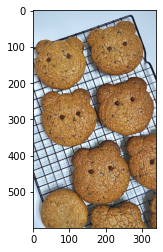

In [10]:
from PIL import Image

img = np.array(Image.open(data.path[362]))
print(img.shape)
plt.imshow(np.array(img))

## 1.2 Train Val set 나누기
음식 카테고리간 균등하게 뽑아오기 위해서 범주당 4개씩 선정하여 파일명, 즉 id를 통해 나누어 주었다.

In [11]:
def train_test_splits(df):
  """
  test data의 선정은 음식카테고리당 4개씩 임의로선정하여 id를 통해 나눠주었음

  """
  start_num = [3,52,78,113,148,171,207,248,295,323,365,403,436,464,500,534,589,612,645,695,738,764,792,836,946]

  val_id_list = []
  for num in start_num:
    atom = [i for i in range(num, num+4)]
    val_id_list.extend(atom)
  print("Validation_id List :", val_id_list)

  train = df.drop(index=val_id_list, axis='indexes')
  val = df.loc[val_id_list,:]
  
  print("Tran set : ")
  display(train)
  print("Val set : ")
  display(val)

  print(f'Train : {train.shape}, Val : {val.shape}')
  return train, val

  


In [12]:
train, val = train_test_splits(data)

Validation_id List : [3, 4, 5, 6, 52, 53, 54, 55, 78, 79, 80, 81, 113, 114, 115, 116, 148, 149, 150, 151, 171, 172, 173, 174, 207, 208, 209, 210, 248, 249, 250, 251, 295, 296, 297, 298, 323, 324, 325, 326, 365, 366, 367, 368, 403, 404, 405, 406, 436, 437, 438, 439, 464, 465, 466, 467, 500, 501, 502, 503, 534, 535, 536, 537, 589, 590, 591, 592, 612, 613, 614, 615, 645, 646, 647, 648, 695, 696, 697, 698, 738, 739, 740, 741, 764, 765, 766, 767, 792, 793, 794, 795, 836, 837, 838, 839, 946, 947, 948, 949]
Tran set : 


,is_low_kcal,carbohydrate,fats,fiber,protein,sugars,path
0,0,0,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
1,0,0,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
2,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
7,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
8,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
...,...,...,...,...,...,...,...
973,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
974,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
975,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
976,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...


Val set : 


,is_low_kcal,carbohydrate,fats,fiber,protein,sugars,path
3,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
4,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
5,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
6,1,1,0,1,0,0,/content/drive/MyDrive/food_classification/ima...
52,1,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
...,...,...,...,...,...,...,...
839,1,1,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
946,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
947,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...
948,0,1,1,0,1,0,/content/drive/MyDrive/food_classification/ima...


Train : (878, 7), Val : (100, 7)


[케라스 ImageDataGenerator](https://keras.io/ja/preprocessing/image/)

## 1.3 이미지 데이터 전처리

In [13]:
from keras.preprocessing.image import ImageDataGenerator as IDG

train_Gen = IDG(rescale=1./255,
                rotation_range = 30, # 임의로 이미지를 회전
                width_shift_range=0.1, # 임의로 이미지를 수평 이동
                height_shift_range=0.1, # 임의로 이미지를 수직 이동
                shear_range=0.2, # 임의로 이미지를 변형
                zoom_range=0.2, # 임의로 이미지를 확대/축소
                horizontal_flip=False, # 수평방향으로 뒤집기
                fill_mode='nearest' # 이미지 경계의 바깥 공간을 어떻게 채울지에 대한 파라미터
                                 )   
val_Gen = IDG(rescale=1./255)
                

trainGenSet = train_Gen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col = data.columns.tolist()[:-1],
    batch_size=128,
    seed=42,
    shuffle=True,
    target_size=(224,224),
    class_mode='raw',
    color_mode='rgb',
    )

valSet = val_Gen.flow_from_dataframe(
    dataframe=val,
    x_col='path',
    y_col = data.columns.tolist()[:-1],
    batch_size=128,
    seed=42,
    shuffle=False,
    target_size=(224,224),
    class_mode='raw',
    color_mode='rgb',
    )

testSet = val_Gen.flow_from_dataframe(
    dataframe=val,
    x_col='path',
    y_col = data.columns.tolist()[:-1],
    batch_size=128,
    seed=42,
    shuffle=False,
    target_size=(224,224),
    class_mode='raw',
    color_mode='rgb',
    )



Found 878 validated image filenames.
Found 100 validated image filenames.
Found 100 validated image filenames.


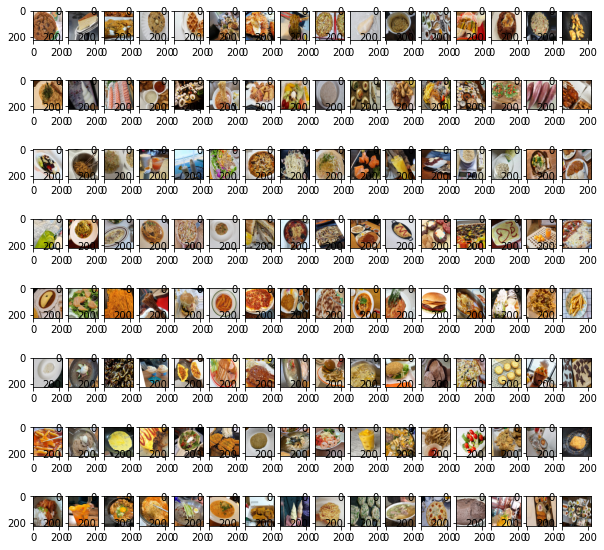

In [14]:
fig = plt.figure(figsize=(10,10))
axs = []

for x_data, t_data in trainGenSet:
  for idx, img in enumerate(x_data):
    axs.append(fig.add_subplot(8,16, idx+1))
    plt.imshow(img)
  break

# 2. 모델 테스트

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


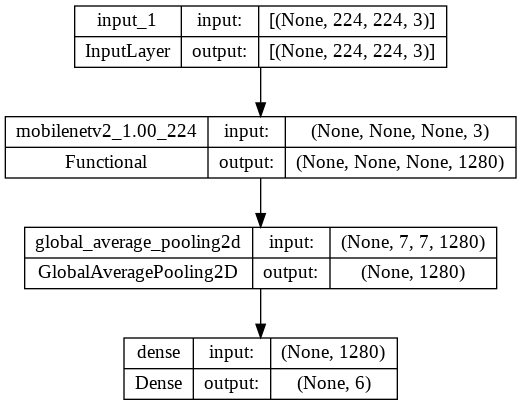

In [1]:
import tensorflow as tf

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.MobileNetV2(include_top=False)(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(6, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-4))

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [2]:
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.01)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(trainGenSet, validation_data=valSet, epochs=10, callbacks=[rlp, es])


NameError: ignored

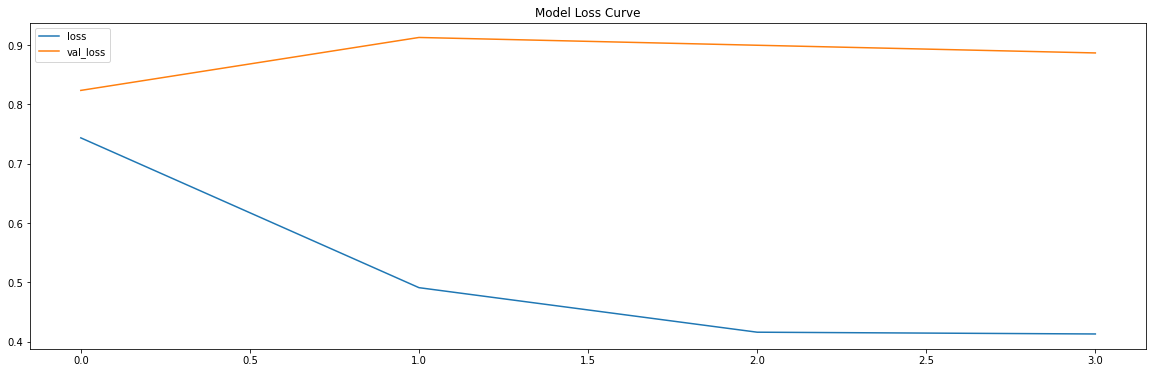

In [17]:
fix, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax, title='Model Loss Curve')

In [ ]:
from keras.utils.vis_utils import plot_model

# 모델
model = VGG19()
plot_model(model, to_file='vgg.png')

In [ ]:
model.summary()